# **Assignment 4**

### **Group 3** - Bethel Mandizha, Miranda Montenegro, Rahul Saha, Zeyu Wang

-----

Copyright 2021 - 2023 Patrick Hall (jphall@gwu.edu), Bethel Mandizha (bethel.mandizha@gwmail.gwu.edu), Miranda Montenegro (miranda.montenegrolopez@gwmail.gwu.edu), Rahul Saha (rahul.saha@gwmail.gwu.edu), & Zeyu Wang (zywang@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

DISCLAIMER: This notebook is not legal or compliance advice.

-----

### **Importing Necessary Libraries**

In [1]:
#Data manipulation, plotting and metrics
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns  
import datetime   
import time  

#Model modules
import h2o                                                    
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  
from h2o.grid.grid_search import H2OGridSearch 
import xgboost as xgb  
import itertools 
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC 

#Setting numpy seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

#Setting number of threads
NTHREAD = 4

#h2o start and clearing of memory
h2o.init(max_mem_size='6G', nthreads=NTHREAD) 
h2o.remove_all()                              
h2o.no_progress() 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-17.0.14+7 (build 17.0.14+7, mixed mode, sharing)
  Starting server from C:\Users\Jing\AppData\Roaming\Python\Python312\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Jing\AppData\Local\Temp\tmpfo9t3v4t
  JVM stdout: C:\Users\Jing\AppData\Local\Temp\tmpfo9t3v4t\h2o_Jing_started_from_python.out
  JVM stderr: C:\Users\Jing\AppData\Local\Temp\tmpfo9t3v4t\h2o_Jing_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 10 days
H2O_cluster_name:,H2O_from_python_Jing_qoltt3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


#### Starting the Global Timer

In [2]:
tic = time.time()

### **Importing Applicable Data**

In [3]:
#Importing pre-processed training data and showing first 5 lines of the dataset
train_data = pd.read_csv('/Users/Jing/Downloads/hmda_train_preprocessed.csv')
train_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0
4,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,1,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0


In [4]:
#Importing pre-processed testing data and showing first 5 lines of the dataset
test_data = pd.read_csv('/Users/Jing/Downloads/hmda_test_preprocessed.csv')
test_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,1,0,-0.514393,-0.039293,0.244394,-0.215304,-0.474263,-0.017786,0.854601
1,1,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,0,-0.162614,0.126830,0.244394,-0.215304,-0.227585,-0.015014,-0.425131
2,2,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,...,1,1,0,-0.646310,0.552520,0.244394,-0.215304,-0.659271,-0.033378,-0.425131
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,3.662982,0.133614,0.244394,-0.215304,2.763389,0.025177,0.306144
4,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,-0.338504,0.552520,0.244394,-0.215304,-0.443428,-0.027834,0.306144


#### Assigning modeling roles for the data

In [5]:
#Setting target and features for the data
target = 'high_priced'
demographic_cols = ['black', 'asian','white', 'amind', 'hipac', 'hispanic', 'non_hispanic', 'male', 'female', 'agegte62', 'agelt62']
features = [col for col in train_data.columns if col not in demographic_cols + ['row_id',target]]

print('target =', target)
print('predictors =', features)

target = high_priced
predictors = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']


### **Fitting the Data**

In [6]:
#Preserve exact reproducibility for this cell
np.random.seed(SEED) 

#Choosing a 70/30 train/test split 
split_ratio = 0.7

#Execute split
split = np.random.rand(len(train_data)) < split_ratio
train = train_data[split]
valid = train_data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


## PART 1: Model Extraction Attack

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [7]:
# params dict for remediated models
rem_params = {'max_bins': 1024,
 'max_interaction_bins': 24,
 'interactions': 5,
 'outer_bags': 8,
 'inner_bags': 0,
 'learning_rate': 0.01,
 'validation_size': 0.5,
 'min_samples_leaf': 1,
 'max_leaves': 5,
 'n_jobs': 4,
 'early_stopping_rounds': 100,
 'random_state': 12345} # YOUR MODEL PARAMETERS HERE!

rem_x_names = ['intro_rate_period_std',
 'debt_to_income_ratio_std',
 'term_360',
 'property_value_std',
 'income_std',
 'debt_to_income_ratio_missing'] # YOUR FEATURES HERE!

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[target])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[target])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7810.


### Model Extraction Attack

#### Generate synthetic data for extraction attack

In [8]:
# best guess at feature distributions
schema_dict = {'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'},
               'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_missing': {'p': 0.05, 'dist': 'binomial'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame

np.random.seed(SEED) # same results each time cell is run

for j in list(schema_dict.keys()): # loop through features

    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'],
                                           size=N)

    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'],
                                                                        size=N)

    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)

# make up for no_intro_rate_period_std scale shift
# random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std']

#### Visualize simulated data

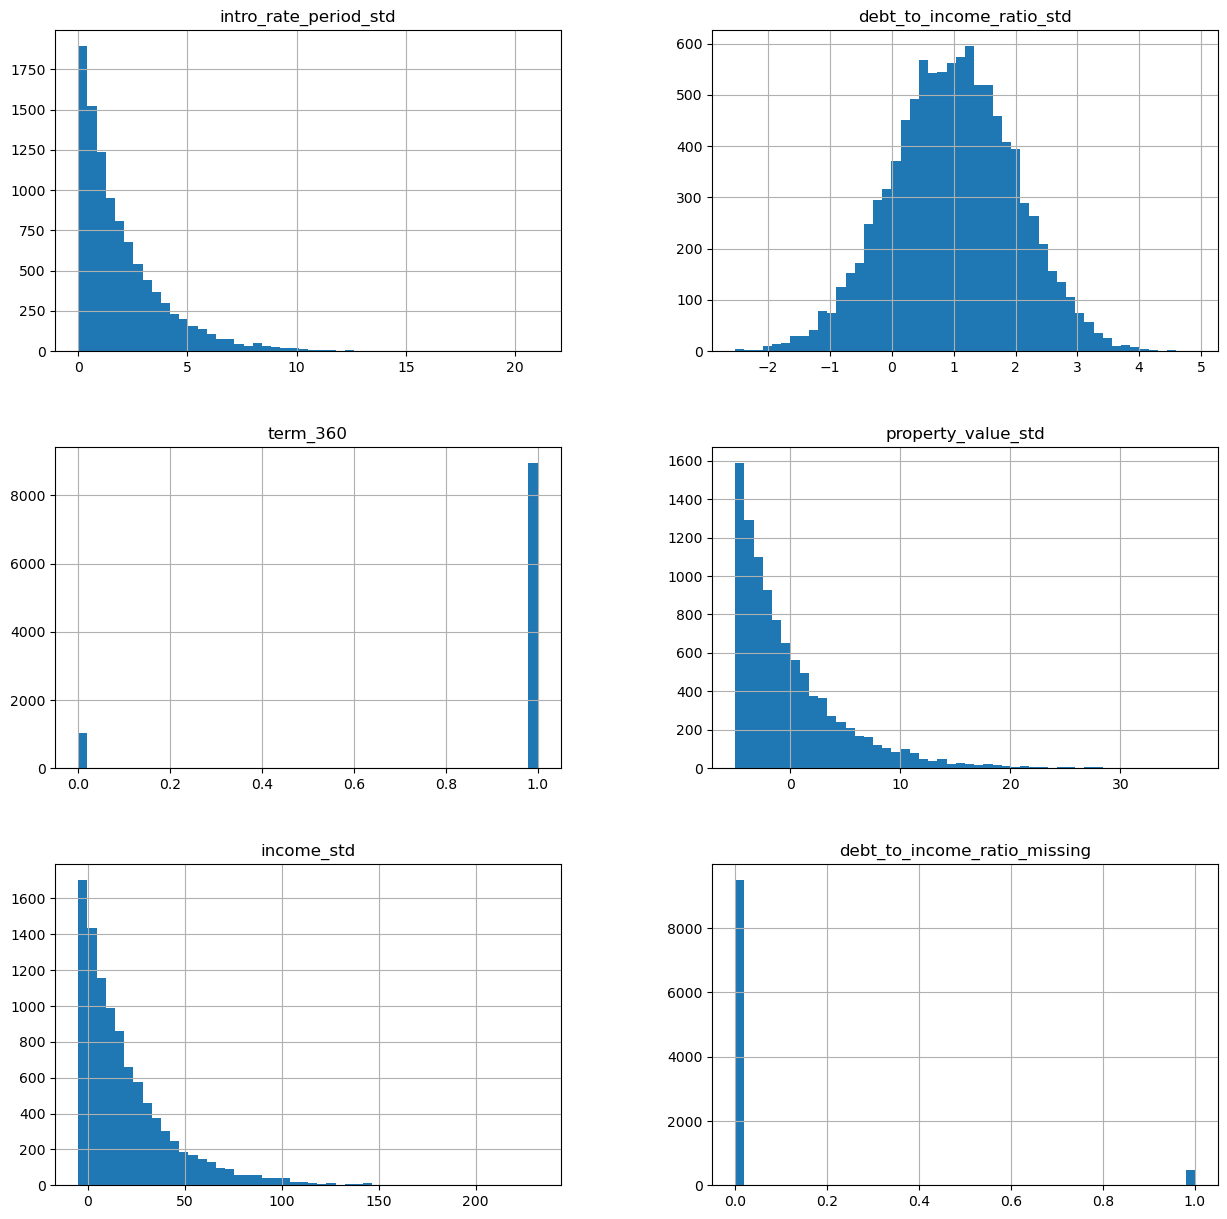

In [9]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

#### First call to blackbox model for predictions on random data

In [10]:
blackbox_phat = pd.DataFrame(rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1], columns=['phat'])
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

,intro_rate_period_std,debt_to_income_ratio_std,term_360,property_value_std,income_std,debt_to_income_ratio_missing,phat
0,5.307581,0.270249,1,1.542979,-1.388380,0,0.000910
1,0.760693,1.215850,1,1.273303,26.605295,0,0.020633
2,0.406483,1.204969,1,-3.948261,34.300354,0,0.033517
3,0.457720,-0.216478,1,0.103183,26.431098,0,0.009665
4,1.677387,1.499916,1,0.233522,-2.397683,0,0.153994


#### Extract a stolen decision tree model

In [11]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    return tree

In [12]:
# Try reconnecting to the existing server
try:
    h2o.init()
except H2OConnectionError:
    # If reconnecting fails, shutdown and restart
    h2o.shutdown(prompt=False)
    h2o.init()

# Now import after initializing H2O
from h2o.estimators.random_forest import H2ORandomForestEstimator  # for decision tree in model extraction

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,41 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 10 days
H2O_cluster_name:,H2O_from_python_Jing_qoltt3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [24]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt',
                      SEED,
                      'Stolen Model')

# Convert H2O MOJO to Graphviz .gv file
!java -cp "C:/Users/Jing/Downloads/h2o-3.46.0.6/h2o.jar" hex.genmodel.tools.PrintMojo --tree 0 -i stolen_dt.zip -o stolen_dt.gv --title "Stolen Model"

# Convert .gv file to .png using Graphviz
! "C:\\Program Files\\Graphviz\\bin\\dot.exe" -Tpng stolen_dt.gv -o stolen_dt.png

# convert h2o MOJO (stolen_dt.zip) into GraphViz file (stolen_dt.png)
%ls

Generated MOJO path:
 C:\Users\Jing\Downloads\stolen_dt.zip
 Volume in drive C has no label.
 Volume Serial Number is 28E2-7A2D

 Directory of C:\Users\Jing\Downloads

04/12/25  04:38 PM    <DIR>          .
04/12/25  04:38 PM    <DIR>          ..
04/12/25  02:55 PM    <DIR>          .ipynb_checkpoints
03/22/25  03:27 PM         2,830,971 01_Explainable_AI_Models.ipynb
01/19/25  01:06 PM           423,877 2023_TaxReturn.pdf
01/13/25  11:37 AM           245,989 2024_W2_Zeyu.pdf
03/25/25  08:15 AM           297,090 assign_1_template.ipynb.txt
03/22/25  02:48 PM           158,046 assignment_1.pdf
03/26/25  07:27 AM           106,529 assignment_2.pdf
04/02/25  09:31 PM            85,728 assignment_3.pdf
03/25/25  09:17 AM         2,987,198 credit_line_increase.csv
11/26/24  10:30 AM           133,449 CV_Template.pdf
04/03/25  02:15 PM           571,004 ds160_p.pdf
03/30/25  10:06 PM            81,658 DSC07966-1 2.JPG
03/30/25  10:12 PM           223,344 DSC07966-1 2.png
11/03/24  10:14 PM  

#### View stolen model

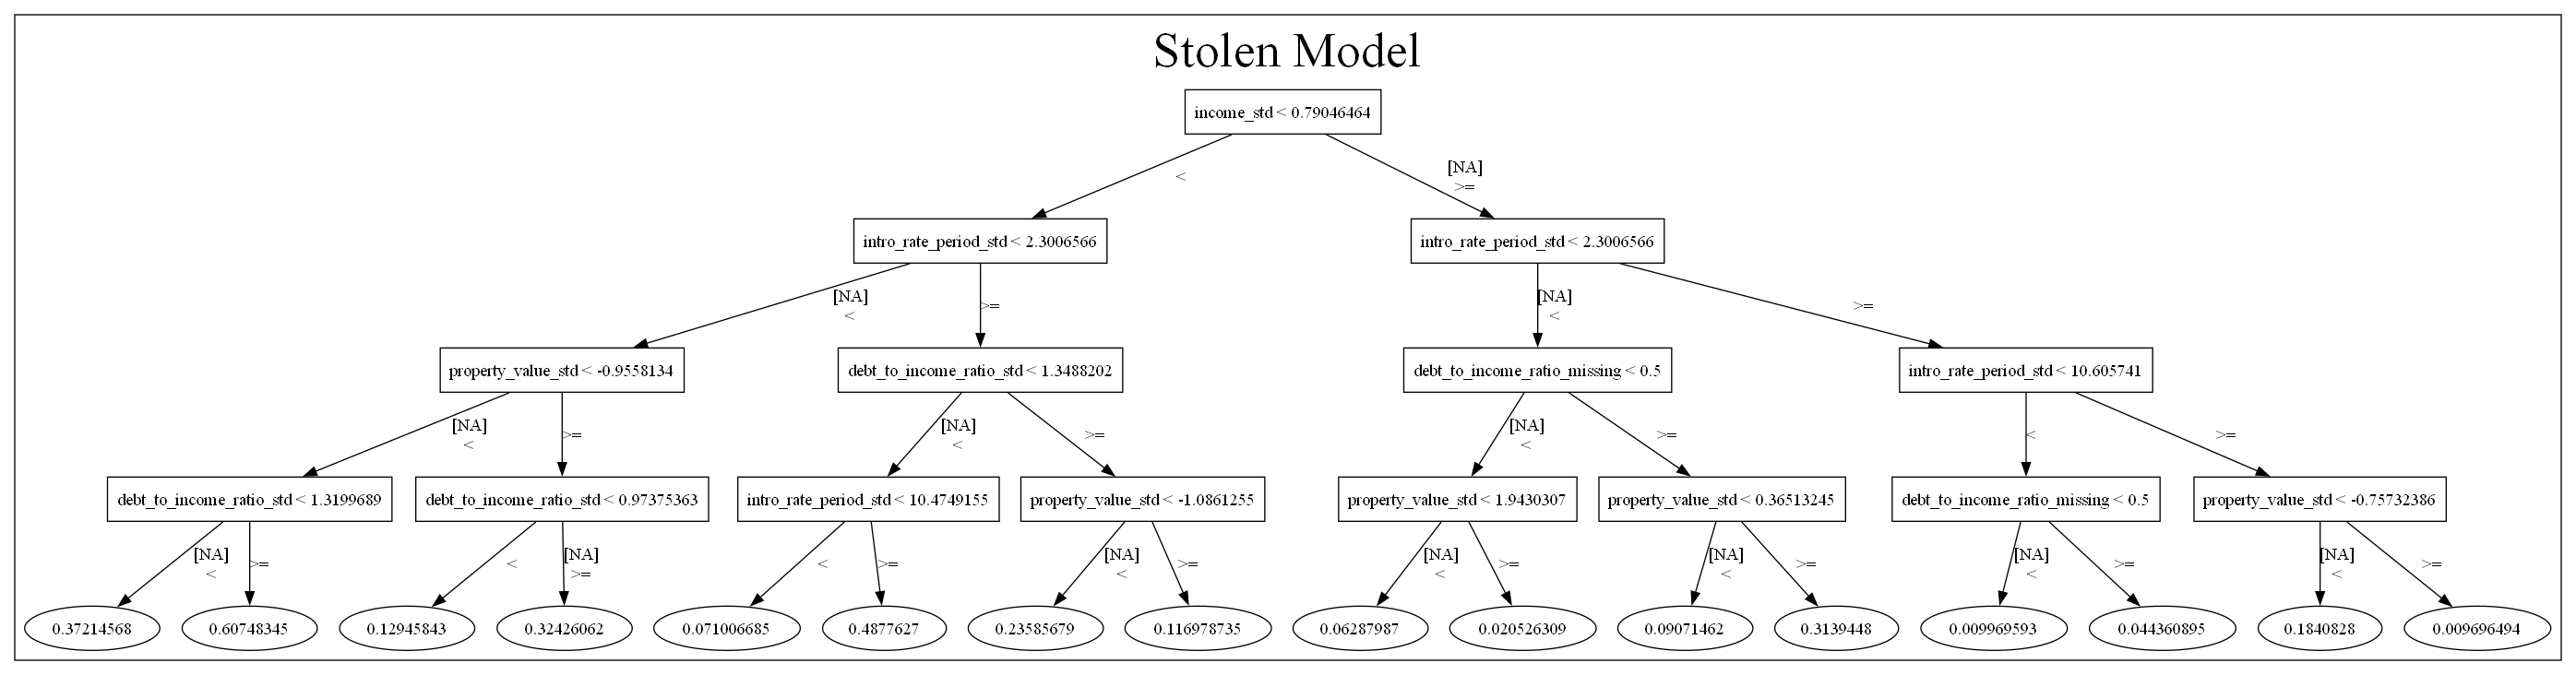

In [25]:
from IPython.display import Image
from IPython.display import display
display(Image(('stolen_dt.png')))

#### Variable importance for stolen model

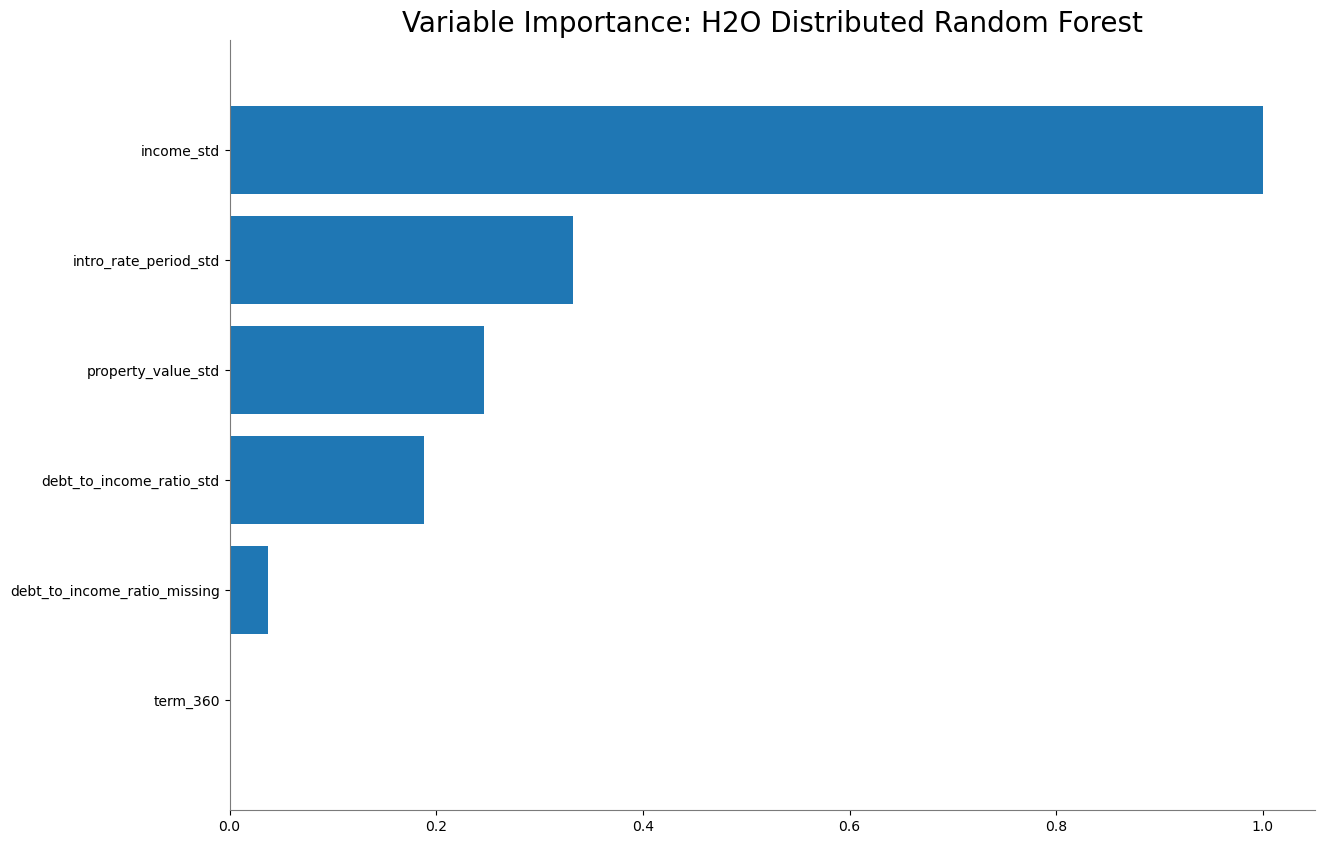

<Figure size 640x480 with 0 Axes>

In [26]:
stolen_dt.varimp_plot()

#### Assess accuracy of stolen model

In [27]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
aic,nan,0.0,nan,nan,nan
loglikelihood,nan,0.0,nan,nan,nan
mae,0.043405,0.0008451,0.0441822,0.0435276,0.0425052
mean_residual_deviance,0.0065336,0.0004329,0.0070333,0.0062928,0.0062746
mse,0.0065336,0.0004329,0.0070333,0.0062928,0.0062746
r2,0.7233211,0.0146399,0.7078493,0.7251583,0.7369556
residual_deviance,0.0065336,0.0004329,0.0070333,0.0062928,0.0062746
rmse,0.0808016,0.0026536,0.0838650,0.0793272,0.0792126
rmsle,0.0626821,0.0017248,0.0645802,0.0622553,0.0612107


## PART 2: Use stolen model to find seed rows for adversary searches

#### Use stolen model to find seed rows for adversary searches

In [28]:
low_adversary_seed = random_frame.loc[
    (random_frame['intro_rate_period_std'] >= 2) & 
    (random_frame['debt_to_income_ratio_std'] >= 1.5) & 
    (random_frame['property_value_std'] >= -1.5) & 
    (random_frame['income_std'] < -1) & 
    (random_frame['term_360'] == 0) & 
    (random_frame['debt_to_income_ratio_missing'] == 1)].mean()

print('Low adversarial example search seed row:')
print(low_adversary_seed)

high_adversary_seed = random_frame.loc[
    (random_frame['intro_rate_period_std'] < 2.26) & 
    (random_frame['debt_to_income_ratio_std'] < 0.5) & 
    (random_frame['property_value_std'] < -1.0) &
    (random_frame['income_std'] > 2.0) & 
    (random_frame['term_360'] == 1) & 
    (random_frame['debt_to_income_ratio_missing'] == 0)].mean()

print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
intro_rate_period_std           2.672756
debt_to_income_ratio_std        2.275553
term_360                        0.000000
property_value_std              1.450236
income_std                     -2.464544
debt_to_income_ratio_missing    1.000000
dtype: float64
High adversarial example search seed row:
intro_rate_period_std            0.915947
debt_to_income_ratio_std        -0.130764
term_360                         1.000000
property_value_std              -3.253141
income_std                      27.462110
debt_to_income_ratio_missing     0.000000
dtype: float64


#### Perturb seed row to find low scoring adversarial examples

In [29]:
# init results frames
low_adversary_frame = pd.DataFrame({'intro_rate_period_std': pd.Series(dtype=np.float64),'debt_to_income_ratio_std': pd.Series(dtype=np.float64),
    'term_360': pd.Series(dtype=np.int64),'property_value_std': pd.Series(dtype=np.float64),'income_std': pd.Series(dtype=np.float64),
    'debt_to_income_ratio_missing': pd.Series(dtype=np.int64)})

# quantiles over which to search
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5]
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

idx = 0
for a in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
    for b in list(random_frame['income_std'].quantile(high_quantiles)):
        for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
            for d in list(random_frame['debt_to_income_ratio_missing'].quantile(low_quantiles)):
                for e in list(random_frame['property_value_std'].quantile(high_quantiles)):
                    for f in [0, 1]:  
                        low_adversary_seed_frame = pd.DataFrame(
                            np.reshape(low_adversary_seed.values, (1, len(rem_x_names))),
                            columns=rem_x_names, index=[idx])
                        low_adversary_seed_frame['intro_rate_period_std'] = a
                        low_adversary_seed_frame['income_std'] = b
                        low_adversary_seed_frame['debt_to_income_ratio_std'] = c
                        low_adversary_seed_frame['debt_to_income_ratio_missing'] = d
                        low_adversary_seed_frame['property_value_std'] = e
                        low_adversary_seed_frame['term_360'] = f
                        low_adversary_frame = pd.concat([low_adversary_frame, low_adversary_seed_frame], axis=0)
                        idx += 1
                    
# view potential low scoring adversarial examples
low_adversary_frame.head()

,intro_rate_period_std,debt_to_income_ratio_std,term_360,property_value_std,income_std,debt_to_income_ratio_missing
0,9.105667,-1.36074,0,18.157891,108.350001,0.0
1,9.105667,-1.36074,1,18.157891,108.350001,0.0
2,9.105667,-1.36074,0,10.193480,108.350001,0.0
3,9.105667,-1.36074,1,10.193480,108.350001,0.0
4,9.105667,-1.36074,0,6.631031,108.350001,0.0


#### Perturb seed row to find high scoring adversarial examples

In [30]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

for a in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):  
    for b in list(random_frame['income_std'].quantile(high_quantiles)):        
        for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):  
            for d in list(random_frame['property_value_std'].quantile(low_quantiles)):    
                for e in [1]:  
                    for f in [0]:  

                        high_adversary_seed_frame = pd.DataFrame(
                            np.reshape(high_adversary_seed.values, (1, len(rem_x_names))),
                            columns=rem_x_names, index=[idx])
                        high_adversary_seed_frame['intro_rate_period_std'] = a
                        high_adversary_seed_frame['income_std'] = b
                        high_adversary_seed_frame['debt_to_income_ratio_std'] = c
                        high_adversary_seed_frame['property_value_std'] = d
                        high_adversary_seed_frame['term_360'] = e
                        high_adversary_seed_frame['debt_to_income_ratio_missing'] = f
                        high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)
                        idx += 1

# view potential high scoring adversarial examples
high_adversary_frame.head()

C:\Users\Jing\AppData\Local\Temp\ipykernel_15384\82145104.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)


,intro_rate_period_std,debt_to_income_ratio_std,term_360,property_value_std,income_std,debt_to_income_ratio_missing
6250,0.022736,-1.36074,1,-4.949140,108.350001,0
6251,0.022736,-1.36074,1,-4.744166,108.350001,0
6252,0.022736,-1.36074,1,-4.501055,108.350001,0
6253,0.022736,-1.36074,1,-3.597843,108.350001,0
6254,0.022736,-1.36074,1,-1.577774,108.350001,0


#### Second call to blackbox API to test adversarial examples

In [31]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat'])
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,intro_rate_period_std,debt_to_income_ratio_std,term_360,property_value_std,income_std,debt_to_income_ratio_missing,phat
640,9.105667,-0.303334,0,18.157891,53.211273,0.0,7.783864e-07
50,9.105667,-0.676000,0,18.157891,108.350001,0.0,7.783864e-07
350,9.105667,-0.303334,0,18.157891,71.084050,0.0,7.783864e-07
390,9.105667,-0.303334,0,18.157891,71.084050,0.0,7.783864e-07
570,9.105667,-0.676000,0,18.157891,53.211273,0.0,7.783864e-07
...,...,...,...,...,...,...,...
6353,0.022736,-1.360740,1,-3.597843,12.448478,0,2.080801e-01
6354,0.022736,-1.360740,1,-1.577774,12.448478,0,2.080801e-01
6351,0.022736,-1.360740,1,-4.744166,12.448478,0,2.080801e-01
6350,0.022736,-1.360740,1,-4.949140,12.448478,0,2.080801e-01


#### End timer

In [32]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 978.36 s.


#### Shutdown H2O

In [33]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)?  Y


H2O session _sid_b663 closed.
